# Gradient-Boosting Quickstart for TPSMAY22

This notebook shows how to train a gradient booster with minimal feature engineering. It wouldn't have been possible without the open-source contributions of other participants, in particular:
- [Analysing Interactions with SHAP](https://www.kaggle.com/code/wti200/analysing-interactions-with-shap) where @wti200 shows how to analyze feature interactions
- [EDA & LGBM Model](https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model) where @cabaxiom introduces the unique_characters feature

For an EDA, see the [separate EDA notebook](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense).

Release notes:
- V1: XGB, 40 features
- V2: LightGBM, 41 features
- V3: 44 features, including three feature interactions
- V4: Plotting and analyzing the training history

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import ListedColormap
import seaborn as sns
from cycler import cycler
from IPython.display import display
import datetime
import scipy.stats

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import HistGradientBoostingClassifier, VotingClassifier
from sklearn.calibration import CalibrationDisplay
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

plt.rcParams['axes.prop_cycle'] = cycler(color=['#ffd700'] +
                                         plt.rcParams['axes.prop_cycle'].by_key()['color'][1:])
plt.rcParams['text.color'] = 'w'


In [2]:
train = pd.read_csv('../input/tabular-playground-series-may-2022/train.csv')
test = pd.read_csv('../input/tabular-playground-series-may-2022/test.csv')


# Top three feature interactions

If we look at 2d-scatterplots of the features, colored by target, we find three feature combinations where the projection is subdivided into three distinct regions with sharp borders in between. The following diagrams show the three different projections which lead to three regions each:

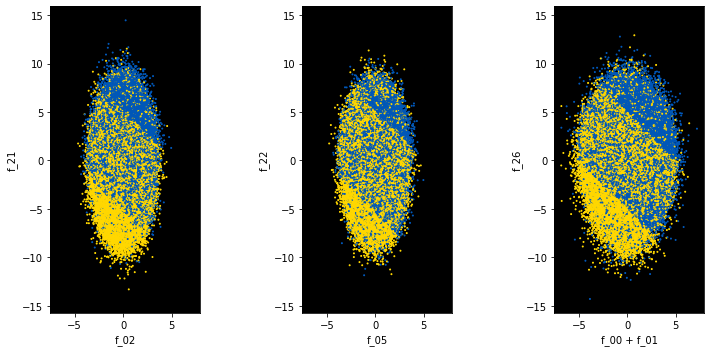

In [3]:
plt.rcParams['axes.facecolor'] = 'k'
plt.figure(figsize=(11, 5))
cmap = ListedColormap(["#ffd700", "#0057b8"])
# target == 0 → yellow; target == 1 → blue

ax = plt.subplot(1, 3, 1)
ax.scatter(train['f_02'], train['f_21'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_02')
ax.set_ylabel('f_21')
ax.set_aspect('equal')
ax0 = ax

ax = plt.subplot(1, 3, 2, sharex=ax0, sharey=ax0)
ax.scatter(train['f_05'], train['f_22'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_05')
ax.set_ylabel('f_22')
ax.set_aspect('equal')

ax = plt.subplot(1, 3, 3, sharex=ax0, sharey=ax0)
ax.scatter(train['f_00'] + train['f_01'], train['f_26'], s=1,
           c=train.target, cmap=cmap)
ax.set_xlabel('f_00 + f_01')
ax.set_ylabel('f_26')
ax.set_aspect('equal')

plt.tight_layout(w_pad=1.0)
plt.savefig('three-projections.png')
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue


We can either hope for the gradient booster to find these borders by itself (and approximate them with decision trees), or we can help it find them.

And how can we help the gradient booster? In the next section, we'll create three ternary categorical features that indicate to what region a sample belongs:
- Top right region (high probability of target == 1) → +1
- Middle region (medium probability of target == 1) → 0
- Bottom left region (low probability of target == 1) → -1


# Feature engineering

We read the data and apply minimal feature engineering:
- We split the `f_27` string into ten separate features as described in the [EDA](https://www.kaggle.com/code/ambrosm/tpsmay22-eda-which-makes-sense).
- We count the unique characters in the string.
- We introduce three categorical features for the feature interactions described above.

In [4]:
for df in [train, test]:
    # Extract the 10 letters of f_27 into individual features
    for i in range(10):
        df[f'ch{i}'] = df.f_27.str.get(i).apply(ord) - ord('A')
        
    # unique_characters feature is from https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
    df["unique_characters"] = df.f_27.apply(lambda s: len(set(s)))
    
    # Feature interactions: create three ternary features
    # Every ternary feature can have the values -1, 0 and +1
    df['i_02_21'] = (df.f_21 + df.f_02 > 5.2).astype(int) - (df.f_21 + df.f_02 < -5.3).astype(int)
    df['i_05_22'] = (df.f_22 + df.f_05 > 5.1).astype(int) - (df.f_22 + df.f_05 < -5.4).astype(int)
    i_00_01_26 = df.f_00 + df.f_01 + df.f_26
    df['i_00_01_26'] = (i_00_01_26 > 5.0).astype(int) - (i_00_01_26 < -5.0).astype(int)
    
features = [f for f in test.columns if f != 'id' and f != 'f_27']
test[features].head(2)

,f_00,f_01,f_02,f_03,f_04,f_05,f_06,f_07,f_08,f_09,...,ch4,ch5,ch6,ch7,ch8,ch9,unique_characters,i_02_21,i_05_22,i_00_01_26
0,0.442517,0.174380,-0.999816,0.762741,0.186778,-1.074775,0.501888,6,6,0,...,1,0,3,11,0,2,5,0,0,1
1,-0.605598,-0.305715,0.627667,-0.578898,-1.750931,1.355550,-0.190911,1,3,4,...,1,0,4,6,2,1,6,0,0,0


# Cross-validation

For cross-validation, we use a simple KFold with five splits. It turned out that the scores of the five splits are very similar so that I usually run only the first split. This one split is good enough to evaluate the model.

Because I want to understand how many iterations are needed, we'll collect some metrics and plot the training history. `early_stopping_round` is set to the very high value of 100000. This means that the algorithm won't stop early, but the setting is necessary to collect the metrics.


In [5]:
%%time
# Cross-validation of the classifier

def my_booster(random_state=1, n_estimators=10000):
    return LGBMClassifier(n_estimators=n_estimators,
                          min_child_samples=80,
                          num_leaves=127,
                          subsample=0.85, subsample_freq=1,
                          metric='auc,binary_logloss,binary_error',
                          max_bins=511, random_state=random_state)
      
print(f"{len(features)} features")
score_list = []
kf = KFold(n_splits=5)
for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
    X_tr = train.iloc[idx_tr][features]
    X_va = train.iloc[idx_va][features]
    y_tr = train.iloc[idx_tr].target
    y_va = train.iloc[idx_va].target
    
    model = my_booster()
    model.fit(X_tr, y_tr,
              early_stopping_rounds=100000, # never stops early
              eval_set = [(X_tr, y_tr),(X_va, y_va)], 
              verbose=1000)
    y_va_pred = model.predict_proba(X_va)[:,1]
    score = roc_auc_score(y_va, y_va_pred)
    print(f"Fold {fold}:                  AUC = {score:.5f}")
    score_list.append(score)
    break # we only need the first fold
    
print(f"OOF AUC:                       {np.mean(score_list):.5f}")

44 features


/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.7/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[1000]	training's auc: 0.999946	training's binary_logloss: 0.0274244	training's binary_error: 0.00295972	valid_1's auc: 0.996607	valid_1's binary_logloss: 0.074934	valid_1's binary_error: 0.0286889
[2000]	training's auc: 1	training's binary_logloss: 0.00748678	training's binary_error: 1.38889e-06	valid_1's auc: 0.996783	valid_1's binary_logloss: 0.0724889	valid_1's binary_error: 0.0281611
[3000]	training's auc: 1	training's binary_logloss: 0.00215011	training's binary_error: 0	valid_1's auc: 0.996846	valid_1's binary_logloss: 0.0755748	valid_1's binary_error: 0.0275556
[4000]	training's auc: 1	training's binary_logloss: 0.000626617	training's binary_error: 0	valid_1's auc: 0.996905	valid_1's binary_logloss: 0.0807633	valid_1's binary_error: 0.0271722
[5000]	training's auc: 1	training's binary_logloss: 0.000183801	training's binary_error: 0	valid_1's auc: 0.996942	valid_1's binary_logloss: 0.0873654	valid_1's binary_error: 0.0267556
[6000]	training's auc: 1	training's binary_logloss: 5.

We save the metrics as csv files in case anybody wants to evaluate them further:

In [6]:
history_tr = pd.DataFrame(model.evals_result_['training'])
history_va = pd.DataFrame(model.evals_result_['valid_1'])
history_tr['accuracy'] = 1 - history_tr.binary_error
history_va['accuracy'] = 1 - history_va.binary_error
history_tr.to_csv('training.csv')
history_va.to_csv('valid.csv')

Now we plot the three metrics *loss*, *accuracy* and *AUC* for the whole training history. In every plot, we mark the point where the metric reaches its optimum.

The estimator overfits terribly: After 2000 iterations, the training predictions are perfect (accuracy and AUC are 1.0). The validation loss reaches its optimum already before 2000 iterations, at a time when validation accuracy and validation auc are still improving. Validation accuracy and validation auc peak several thousand iterations later.

**Insight:** Don't stop lightgbm early when the validation loss stops improving! Wait until validation auc peaks!


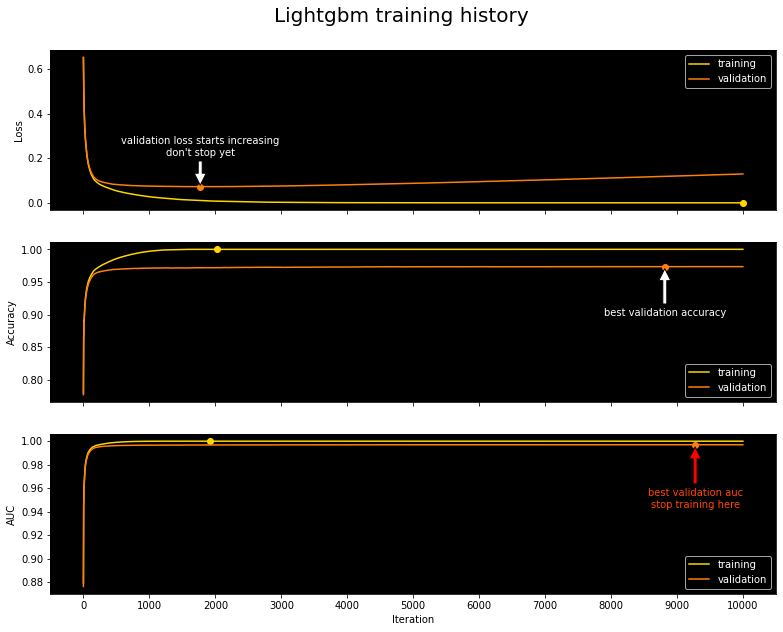

Validation AUC peaks at iteration 9275 with score 0.99698


In [7]:
plt.rcParams['axes.facecolor'] = 'k'
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(13, 10), sharex=True)

ax1.plot(history_tr.index, history_tr.binary_logloss, label='training')
ax1.plot(history_va.index, history_va.binary_logloss, label='validation')
m = history_tr.binary_logloss.argmin()
ax1.scatter([m], [history_tr.binary_logloss[m]])
m = history_va.binary_logloss.argmin()
ax1.scatter([m], [history_va.binary_logloss[m]])
ax1.legend()
ax1.set_ylabel('Loss')
ax1.annotate('validation loss starts increasing\ndon\'t stop yet',
            xy=(m, history_va.binary_logloss[m]), xycoords='data',
            xytext=(m, 0.3), textcoords='data', color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

ax2.plot(history_tr.index, history_tr.accuracy, label='training')
ax2.plot(history_va.index, history_va.accuracy, label='validation')
m = history_tr.accuracy.argmax()
ax2.scatter([m], [history_tr.accuracy[m]])
m = history_va.accuracy.argmax()
ax2.scatter([m], [history_va.accuracy[m]])
ax2.legend(loc='lower right')
ax2.set_ylabel('Accuracy')
ax2.annotate('best validation accuracy',
            xy=(m, history_va.accuracy[m]), xycoords='data',
            xytext=(m, 0.91), textcoords='data', color='white',
            arrowprops=dict(facecolor='white', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

ax3.plot(history_tr.index, history_tr.auc, label='training')
ax3.plot(history_va.index, history_va.auc, label='validation')
m = history_tr.auc.argmax()
ax3.scatter([m], [history_tr.auc[m]])
auc_peak = history_va.auc.argmax()
m = auc_peak
ax3.scatter([m], [history_va.auc[m]])
ax3.legend(loc='lower right')
ax3.set_ylabel('AUC')
ax3.set_xlabel('Iteration')
ax3.set_xticks(np.linspace(0, 10000, 11))
ax3.annotate('best validation auc\nstop training here',
            xy=(m, history_va.auc[m]), xycoords='data',
            xytext=(m, 0.96), textcoords='data', color='orangered',
            arrowprops=dict(facecolor='red', shrink=0.05),
            horizontalalignment='center', verticalalignment='top')

plt.suptitle('Lightgbm training history', y=0.94, fontsize=20, color='k')
plt.savefig('history.png')
plt.show()
plt.rcParams['axes.facecolor'] = '#0057b8' # blue

print(f"Validation AUC peaks at iteration {auc_peak} with score {history_va.auc[auc_peak]:.5f}")

# Three diagrams for model evaluation

We plot the ROC curve just because it looks nice. The area under the red curve is the score of our model.


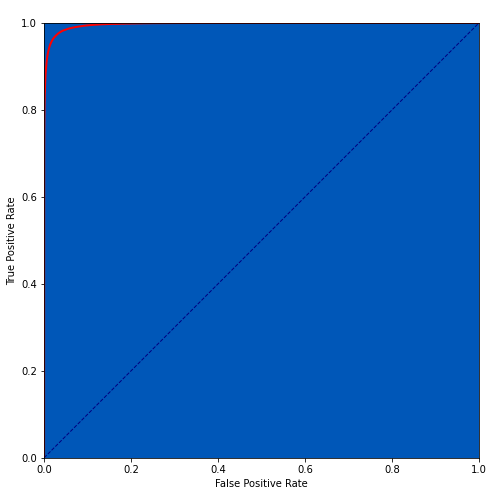

In [8]:
# Plot the roc curve for the last fold
def plot_roc_curve(y_va, y_va_pred):
    plt.figure(figsize=(8, 8))
    fpr, tpr, _ = roc_curve(y_va, y_va_pred)
    plt.plot(fpr, tpr, color='r', lw=2)
    plt.plot([0, 1], [0, 1], color="navy", lw=1, linestyle="--")
    plt.gca().set_aspect('equal')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver operating characteristic")
    plt.show()

plot_roc_curve(y_va, y_va_pred)

Second, we plot a histogram of the out-of-fold predictions. Many predictions are near 0.0 or near 1.0; this means that in many cases the classifier's predictions have high confidence:

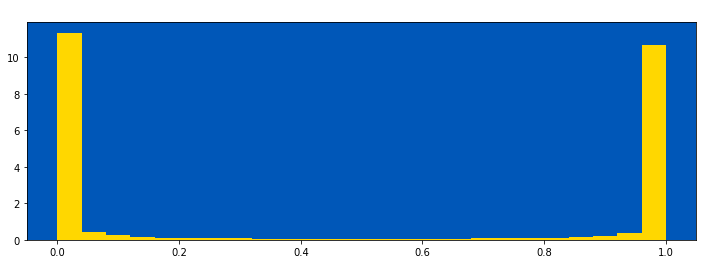

In [9]:
plt.figure(figsize=(12, 4))
plt.hist(y_va_pred, bins=25, density=True)
plt.title('Histogram of the oof predictions')
plt.show()


Finally, we plot the calibration curve. 

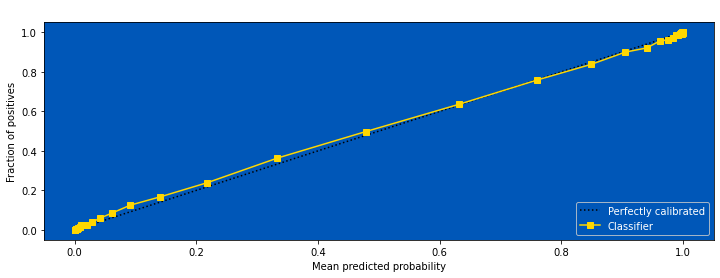

In [10]:
plt.figure(figsize=(12, 4))
CalibrationDisplay.from_predictions(y_va, y_va_pred, n_bins=100, strategy='quantile', ax=plt.gca())
plt.title('Probability calibration')
plt.show()

# Submission

For the submission, we re-train the model on the complete training data with several different seeds and then submit the mean of the predicted ranks. We set `n_estimators` to the number of iterations which gave the best auc in cross-validation.

In [11]:
%%time
# Create submission
print(f"{len(features)} features")
np.set_printoptions(precision=4)

X_tr = train[features]
y_tr = train.target

pred_list = []
for seed in range(10):
    model = my_booster(random_state=seed, n_estimators=auc_peak)
    model.fit(X_tr.values, y_tr)
    pred_list.append( (model.predict_proba(test[features].values)[:,1]))
    print(f"{seed:2}", pred_list[-1])
print()
submission = test[['id']].copy()
submission['target'] = np.array(pred_list).mean(axis=0)
submission.to_csv('submission.csv', index=False)
submission

44 features
 0 [1.0000e+00 1.0000e+00 9.1293e-30 ... 7.1896e-06 8.3006e-12 3.5590e-35]
 1 [1.0000e+00 1.0000e+00 1.0085e-28 ... 8.1160e-06 4.3603e-11 6.0343e-35]
 2 [1.0000e+00 1.0000e+00 4.2024e-28 ... 7.0931e-05 6.5180e-11 1.2011e-34]
 3 [1.0000e+00 1.0000e+00 1.0421e-28 ... 1.0574e-04 3.2165e-11 1.0010e-33]
 4 [1.0000e+00 1.0000e+00 4.0840e-27 ... 1.5274e-05 1.8245e-09 2.4163e-34]
 5 [1.0000e+00 1.0000e+00 7.9091e-28 ... 2.7700e-05 1.6459e-10 1.3250e-35]
 6 [1.0000e+00 1.0000e+00 9.3518e-30 ... 5.7932e-06 3.1088e-10 3.3644e-35]
 7 [1.0000e+00 1.0000e+00 6.2885e-28 ... 1.2970e-06 1.0531e-10 7.9152e-34]
 8 [1.0000e+00 1.0000e+00 1.8798e-28 ... 6.1320e-06 1.0939e-10 1.1430e-34]
 9 [1.0000e+00 1.0000e+00 5.9423e-28 ... 5.4568e-06 5.1918e-09 4.4847e-34]

CPU times: user 16h 52min 26s, sys: 2min 23s, total: 16h 54min 50s
Wall time: 4h 18min 17s


,id,target
0,900000,1.000000e+00
1,900001,1.000000e+00
2,900002,6.929726e-28
3,900003,2.609206e-11
4,900004,1.000000e+00
...,...,...
699995,1599995,6.198084e-01
699996,1599996,1.000000e+00
699997,1599997,2.536296e-05
699998,1599998,7.855655e-10


# What next?

Now it's your turn! Try to improve this model by
- Engineering more features
- Tuning hyperparameters
- Replacing LightGBM by XGBoost, HistGradientBoostingClassifier or CatBoost 

Or, if you prefer neural networks, have a look at the [Advanced Keras Model](https://www.kaggle.com/ambrosm/tpsmay22-advanced-keras).
